In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold 
import math
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn import metrics
from scipy import stats as stats
%matplotlib inline 

In [ ]:
### Process Data 
# Read Local CSV of training data
properties = ['FUBrain', 'RenClear', 'FreeSolv', 'MicroClear', 'HemoTox', 'HepClear', 'Caco2', 'Sol', 'VDss', 'HalfLifeMWAdjusted']

for property in properties:
    dataset = '{}.csv'.format(property)

    # 3 Options of Datasets - Uncomment the appropriate one
    # 1 - ChemProp
    predictions = pd.read_csv('{}_DeepDelta_50_Epoch_Trad_1.csv'.format(name)).T
    predictions.columns =['True', 'Delta']

    # 2 - DeepDelta
    #predictions = pd.read_csv('{}_DeepDelta_1.csv'.format(name)).T
    #predictions.columns =['True', 'Delta', 'Traditional']

    # 3 - Random Forest 
    #predictions = pd.read_csv('{}_CV_RF_1.csv'.format(name))
    #predictions.columns =['Ignore', 'True', 'Delta']

    # Prepare Scaffolds
    mols = [Chem.MolFromSmiles(s) for s in dataframe.SMILES]
    scaffolds = [Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(m)) for m in mols]
    data = pd.DataFrame(data={'Scaffold':  scaffolds})
    del dataframe

    # Set up for cross validation
    from sklearn.model_selection import KFold
    cv = KFold(n_splits=10, random_state=1, shuffle=True)

    # use garbage collection to save on space
    import gc
    print(gc.get_count())
    gc.collect()
    print(gc.get_count())

    # Perform cross validation and save the scaffolds from this
    datapoint_x = []
    datapoint_y = []

    for train_index, test_index in cv.split(data):

    train_df = data[data.index.isin(train_index)]
    test_df = data[data.index.isin(test_index)]
    pair_subset_test = pd.merge(test_df, test_df, how='cross')
    datapoint_x += [pair_subset_test.Scaffold_x]
    datapoint_y += [pair_subset_test.Scaffold_y]
    del pair_subset_test

    datapoints = pd.DataFrame(data={'X':  np.concatenate(datapoint_x), 'Y':  np.concatenate(datapoint_y)})

    # Add the deltas and predicted deltas
    trues = predictions['True']
    trues = [float(i) for i in trues]
    datapoints['True'] = trues

    Deltas = predictions['Delta']
    Deltas = [float(i) for i in Deltas]
    datapoints['Delta'] = Deltas


    # Grab the datapoints with matching scaffolds into a separate dataframe
    final_df = pd.DataFrame(columns = ['X', 'Y', 'True', 'Delta'])

    for i in range(len(datapoints)):
    if datapoints['X'][i] == datapoints['Y'][i]:
        inter_df = pd.DataFrame({'X': [datapoints['X'][i]], 'Y': [datapoints['Y'][i]], 'True': [datapoints['True'][i]], 'Delta': [datapoints['Delta'][i]]})
        final_df = pd.concat([final_df, inter_df])

    # Grab the nonmatching datapoints
    nonmatching = pd.merge(datapoints,final_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

,Scaffold
0,O=C(NN1CCCCC1)c1cc(-c2ccccc2)n(-c2ccccc2)n1
1,c1ccc2c(c1)Sc1ccccc1N2CCC1CCCCN1
2,O=C(Nc1nccs1)C1c2ccccc2Oc2ccccc21
3,O=C1c2ccccc2C(=O)c2cc3c(cc21)CCC[C@@H]3O[C@H]1...
4,c1ccc([C@@]23CNC[C@@H]2[C@H]3COCC2CC2)cc1
...,...
248,c1ccoc1
249,c1ccccc1
250,O=C(c1ccccc1)N1CCn2c(nnc2-c2ncns2)C1
251,O=C1CCCN1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

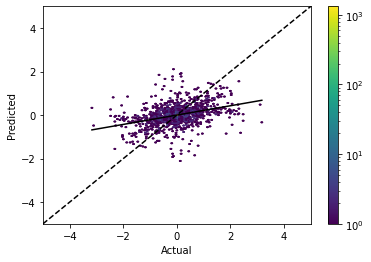

In [ ]:
### Plotting Scaffold Matching ###
fig, ax = plt.subplots()

ax.hexbin(final_df["True"], (final_df['Delta']), gridsize=(100),
                norm=matplotlib.colors.LogNorm(), mincnt=1)
fig.colorbar(ax.hexbin(final_df["True"], (final_df['Delta']), gridsize=(100),
                norm=matplotlib.colors.LogNorm(), mincnt=1))

#line of best fit
plt.plot(np.unique(final_df["True"]), np.poly1d(np.polyfit(final_df["True"], (final_df['Delta']), 1))(np.unique(final_df["True"])), 'k')

i = 5

# X=Y line on the plot
ax.plot([-i, i], [-i, i], 'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([-i, i])
ax.set_ylim([-i, i])
plt.savefig("Scaff-Matching-ChempProp50-{}-HB.png".format(name), facecolor='white', dpi = 600)

#plt.style.use('default')
#plt.show()

In [ ]:
print('Scaffold Matching')

pearson = stats.pearsonr(final_df["True"], (final_df['Delta']))
MAE = metrics.mean_absolute_error(final_df["True"], (final_df['Delta']))
RMSE = math.sqrt(metrics.mean_squared_error(final_df["True"], (final_df['Delta'])))

scoring = pd.DataFrame({'Metric': ['Pearson\'s r', 'MAE', 'RMSE'], 'Value': [round(pearson[0], 3), round(MAE, 3), round(RMSE, 3)]})
scoring

Scaffold Matching


,Metric,Value
0,Pearson's r,0.142
1,MAE,0.095
2,RMSE,0.294


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

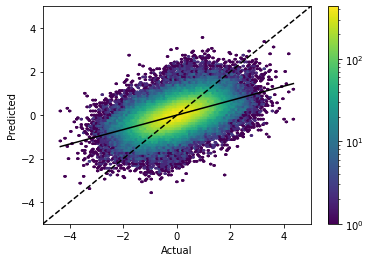

In [ ]:
### Plotting Scaffold Not Matching ###

fig, ax = plt.subplots()

ax.hexbin(nonmatching["True"], (nonmatching['Delta']), gridsize=(100),
                norm=matplotlib.colors.LogNorm(), mincnt=1)
fig.colorbar(ax.hexbin(nonmatching["True"], (nonmatching['Delta']), gridsize=(100),
                norm=matplotlib.colors.LogNorm(), mincnt=1))

#line of best fit
plt.plot(np.unique(nonmatching["True"]), np.poly1d(np.polyfit(nonmatching["True"], (nonmatching['Delta']), 1))(np.unique(nonmatching["True"])), 'k')


# X=Y line on the plot
ax.plot([-i, i], [-i, i], 'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([-i, i])
ax.set_ylim([-i, i])
plt.savefig("Scaff-Nonmatching-ChempProp50-{}-HB.png".format(name), facecolor='white', dpi = 600)

#plt.style.use('default')
#plt.show()


In [ ]:
print('Scaffold Not Matching')

pearson = stats.pearsonr(nonmatching["True"], (nonmatching['Delta']))
MAE = metrics.mean_absolute_error(nonmatching["True"], (nonmatching['Delta']))
RMSE = math.sqrt(metrics.mean_squared_error(nonmatching["True"], (nonmatching['Delta'])))

scoring = pd.DataFrame({'Metric': ['r', 'MAE', 'RMSE'], 'Value': [round(pearson[0], 3), round(MAE, 3), round(RMSE, 3)]})
scoring


Scaffold Not Matching


,Metric,Value
0,r,0.488
1,MAE,0.770
2,RMSE,0.977
